Yet to finalised

Consistency in variance (Add GARCH family or multiplier in terms of time)
QC on ACF and PACF
Bayesian MLE of MSAR
Research on changes in variance

Possible improvement
Diff, GARCH/Multiplier, Seasonality QC, Removal of sudden spike due to extreme/unexpected event
Prediction of extreme event... Next research? (Frequency severity model)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_excel('KLCI Prediction.xlsx').iloc[:, 1:]
date = pd.read_excel('KLCI Prediction.xlsx').iloc[:, 0:1]

# From Data preprocessing
scaler = StandardScaler()
final_data = np.array(data).reshape(-1,1)
final_data = scaler.fit_transform(final_data)

In [3]:
help(sm.tsa.MarkovAutoregression)

Help on class MarkovAutoregression in module statsmodels.tsa.regime_switching.markov_autoregression:

class MarkovAutoregression(statsmodels.tsa.regime_switching.markov_regression.MarkovRegression)
 |  MarkovAutoregression(endog, k_regimes, order, trend='c', exog=None, exog_tvtp=None, switching_ar=True, switching_trend=True, switching_exog=False, switching_variance=False, dates=None, freq=None, missing='none')
 |
 |  Markov switching regression model
 |
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  k_regimes : int
 |      The number of regimes.
 |  order : int
 |      The order of the autoregressive lag polynomial.
 |  trend : {'n', 'c', 't', 'ct'}
 |      Whether or not to include a trend. To include an constant, time trend,
 |      or both, set `trend='c'`, `trend='t'`, or `trend='ct'`. For no trend,
 |      set `trend='n'`. Default is a constant.
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  ex

In [4]:
# Can only run until new 22 data, else SVD will not converge
# May be due to inconsistent with AR 1 process
# However, from the downward trend, we may infer that it is bear throughout the year

MSAR = sm.tsa.MarkovAutoregression(
                endog = final_data[:-30],
                k_regimes=2,
                order=1,
                switching_variance=True,
                trend='t'
            )

Model = MSAR.fit(maxiter=10000)
Model.summary()
# 3 regimes always have issues NaN in some parameters
# Maximum Likelihood Optimization failed when using trend=c (constant term)
# trend = ct always yield NaN in AIC, BIC, Loglikelihood

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                 1114
Model:             MarkovAutoregression   Log Likelihood                1375.232
Date:                  Tue, 24 Dec 2024   AIC                          -2734.465
Time:                          03:59:03   BIC                          -2694.339
Sample:                               0   HQIC                         -2719.294
                                 - 1114                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.001      1.353      0.176      -0.000       0.002
sigma2         0.0109      0.001      8.946      0.000       0.008       0.013
ar.L1          0.9927      0.007    138.581      0.000       0.979       1.007
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.001      1.626      0.104      -0.000       0.002
sigma2         0.0024      0.000      7.499      0.000       0.002       0.003
ar.L1          0.9956      0.002    501.813      0.000       0.992       1.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9502      0.023     40.514      0.000       0.904       0.996
p[1->0]        0.0315      0.010      3.248      0.001       0.012       0.050
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

(1114, 2)


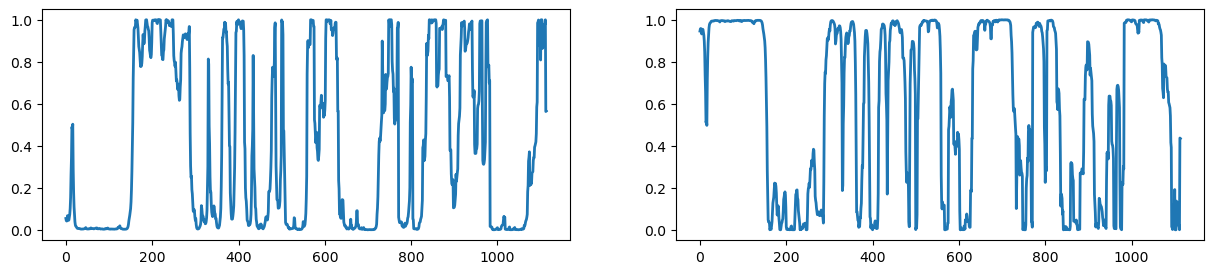

In [5]:
smoprob = Model.smoothed_marginal_probabilities
filprob = Model.filtered_marginal_probabilities # Not used
# print(smoprob.head())
print(smoprob.shape)

fig, axes = plt.subplots(1,2, figsize=(15, 3))

axes[0].plot(smoprob[:,0], lw=2)
axes[1].plot(smoprob[:,1], lw=2)
# axes[2].plot(smoprob[2])

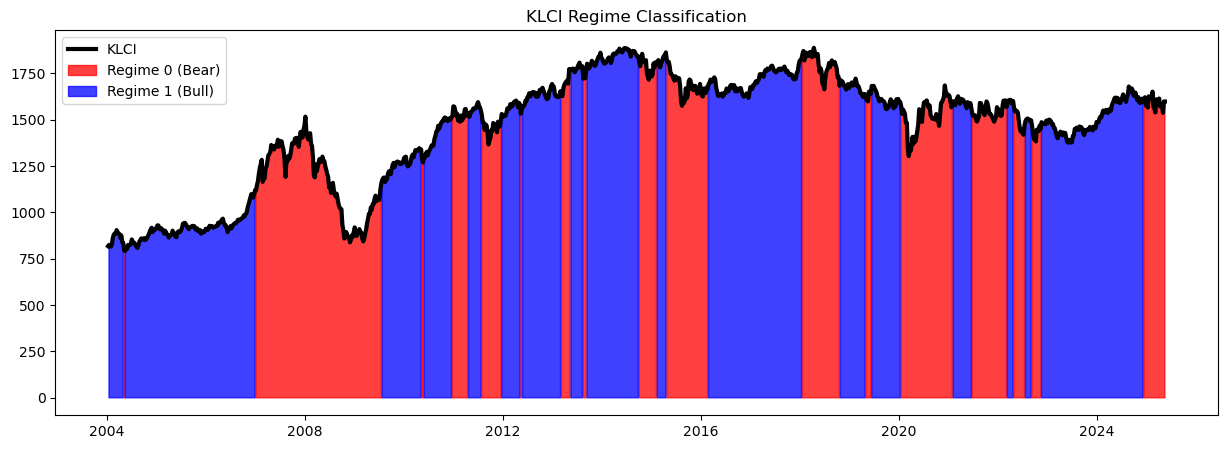

In [17]:
# Most likely regime at each time step based on smoothed probabilities
regime = np.argmax(smoprob, axis=1)

plt.figure(figsize=(15,5))
extended_date_range = pd.date_range('2004-01-12', periods=len(data[:-30]), freq='W-Mon')
plt.plot(extended_date_range, data[:-30], label='KLCI', color='black', lw=3);

# Draw filled boxes under the region
plt.fill_between(extended_date_range[1:], data.iloc[1:-30,0], where=(regime == 0), color='red', alpha=0.75, label='Regime 0 (Bear)')
plt.fill_between(extended_date_range[1:], data.iloc[1:-30,0], where=(regime == 1), color='blue', alpha=0.75, label='Regime 1 (Bull)')
# plt.fill_between(data.index[2:], data[2:], where=(regimes == 2), color='red', alpha=0.5, label='Regime 2')


plt.title('KLCI Regime Classification')
plt.legend();

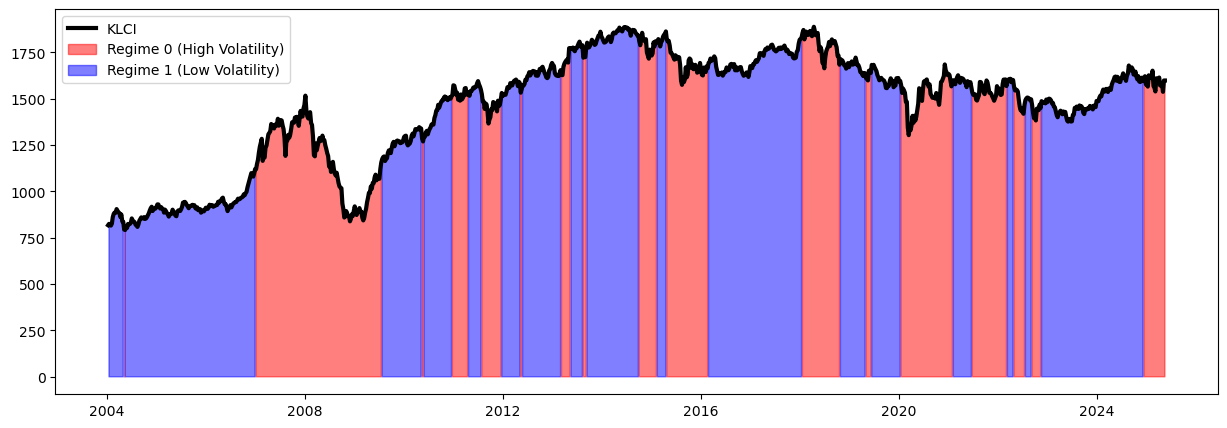

In [18]:
# Most likely regime at each time step based on smoothed probabilities
regime = np.argmax(smoprob, axis=1)

plt.figure(figsize=(15,5))
extended_date_range = pd.date_range('2004-01-12', periods=len(data[:-30]), freq='W-Mon')
plt.plot(extended_date_range, data[:-30], label='KLCI', color='black', lw=3);

# Draw filled boxes under the region
plt.fill_between(extended_date_range[1:], data.iloc[1:-30,0], where=(regime == 0), color='red', alpha=0.5, label='Regime 0 (High Volatility)')
plt.fill_between(extended_date_range[1:], data.iloc[1:-30,0], where=(regime == 1), color='blue', alpha=0.5, label='Regime 1 (Low Volatility)')
# plt.fill_between(data.index[2:], data[2:], where=(regimes == 2), color='red', alpha=0.5, label='Regime 2')

plt.legend();